In [ ]:
import sqlite3, json, pandas as pd, datetime as dt, re

MS_PER_DAY = 86_400_000

conn = sqlite3.connect("mochi.db")
cur = conn.execute(
    'SELECT json FROM "by-sequence" WHERE json LIKE \'%"type":"card"%\''
)

def t(ms_string):
    return dt.datetime.utcfromtimestamp(int(ms_string[2:]) / 1000)

def get_interval(r):
    """Return an int number of days, or None if we can’t infer it."""
    if "~:interval" in r:  # normal case
        return r["~:interval"]

    # Fallback: compute from due-date delta if both fields exist
    if "~:due" in r and "~:date" in r:
        delta_ms = int(r["~:due"][2:]) - int(r["~:date"][2:])
        return max(round(delta_ms / MS_PER_DAY), 0)

    return None

rows = []
for (blob,) in cur.fetchall():
    data = json.loads(blob)["transit-data"]
    deck = data["~:deck-id"]
    for r in data["~:reviews"]:
        rating = r.get("~:rating") or ("good" if r.get("~:remembered?") else "fail")

        rows.append(
            {
                "deck": deck,
                "card_id": data["~:id"],
                "when": t(r["~:date"]),
                "rating": rating,
                "interval": get_interval(r),
                "ease": r.get("~:ease"),
            }
        )

reviews = pd.DataFrame(rows)

/var/folders/z9/j5ml_rlj0bl6bq9136k9lb8r0000gn/T/ipykernel_78947/1356689098.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return dt.datetime.utcfromtimestamp(int(ms_string[2:]) / 1000)


In [ ]:
# Setup – stay tidy
reviews["date"] = reviews["when"].dt.date
reviews["day"] = reviews["when"].dt.floor("d")
ratings_order = ["easy", "good", "hard", "fail"]

Longest streak: 1 days


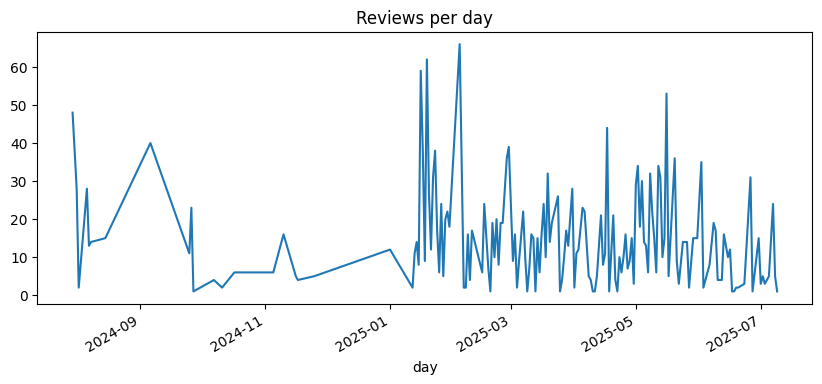

In [ ]:
# Daily review load & streaks
daily = reviews.groupby("day").size()
daily.plot(title="Reviews per day", figsize=(10, 4))
print(
    f"Longest streak: {(daily > 0).astype(int).groupby(daily.gt(0).cumsum()).sum().max()} days"
)

In [ ]:
# Success rate per deck
success = reviews.assign(hit=reviews.rating.isin(["easy", "good"]))
deck_stats = (
    success.groupby("deck")["hit"]
    .agg(["count", "mean"])
    .rename(columns={"count": "reviews", "mean": "success_rate"})
    .sort_values("success_rate")
)
display(deck_stats)

,reviews,success_rate
deck,,
~:jsXcMkuE,235,0.859574
~:1Ub3qL1z,9,0.888889
~:XI6LXmU0,30,0.900000
~:2lfcNYxt,52,0.903846
~:EVWAwWe2,156,0.916667
~:lrz3hHIN,44,0.931818
~:bcTd7xSI,1434,0.940028
~:MT7IYDYL,54,0.962963
~:H1O1RY7M,200,0.970000


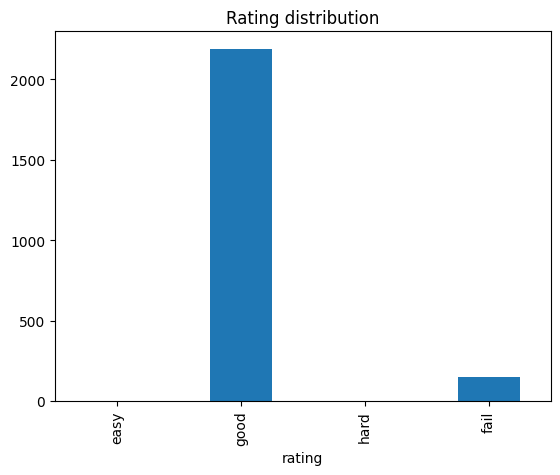

In [ ]:
# Rating distribution (overall health)
dist = (
    reviews["rating"]
    .value_counts()
    .reindex(ratings_order, fill_value=0)
    .plot(kind="bar", title="Rating distribution")
)

rating
fail    Axes(0.125,0.11;0.775x0.77)
good    Axes(0.125,0.11;0.775x0.77)
Name: interval, dtype: object

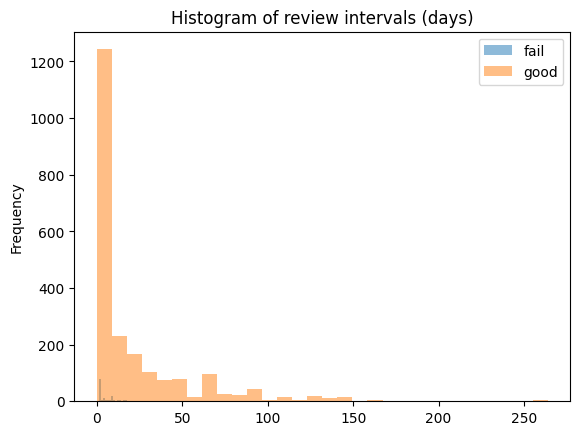

In [ ]:
# Interval growth (are you actually spacing?)
(
    reviews[reviews.interval.notna()]
    .groupby("rating")["interval"]
    .plot(
        kind="hist",
        alpha=0.5,
        bins=30,
        legend=True,
        title="Histogram of review intervals (days)",
    )
)

<Axes: title={'center': '30-day rolling mean of ease factor'}, xlabel='when'>

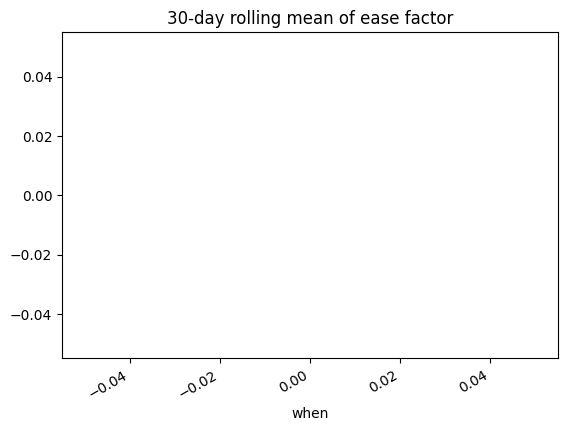

In [ ]:
# Ease-factor drift over time
(
    reviews.dropna(subset=["ease"])
    .set_index("when")["ease"]
    .rolling("30D")
    .mean()
    .plot(title="30-day rolling mean of ease factor")
)

In [ ]:
# 6  Identify leeches (time sinks)
# define a leech as ≥4 fails + fail ratio ≥25 %
leech_table = (
    reviews[reviews.rating == "fail"]
    .groupby("card_id")
    .size()
    .to_frame("fails")
    .join(reviews.groupby("card_id").size().to_frame("total"))
    .assign(fail_rate=lambda d: d.fails / d.total)
    .query("fails >= 4 and fail_rate >= 0.25")
    .sort_values("fail_rate", ascending=False)
)
display(leech_table.head(10))

,fails,total,fail_rate
card_id,,,
~:iIOCfOxp,7,13,0.538462
~:nrefUMnU,9,17,0.529412
~:6VZE5T4w,4,8,0.500000
~:6oPbUdxr,4,8,0.500000
~:QUtmIrhf,4,10,0.400000
~:pLg8tc7O,4,13,0.307692
~:u4zruLGI,4,15,0.266667


<Axes: title={'center': 'Cards due each day'}, xlabel='due'>

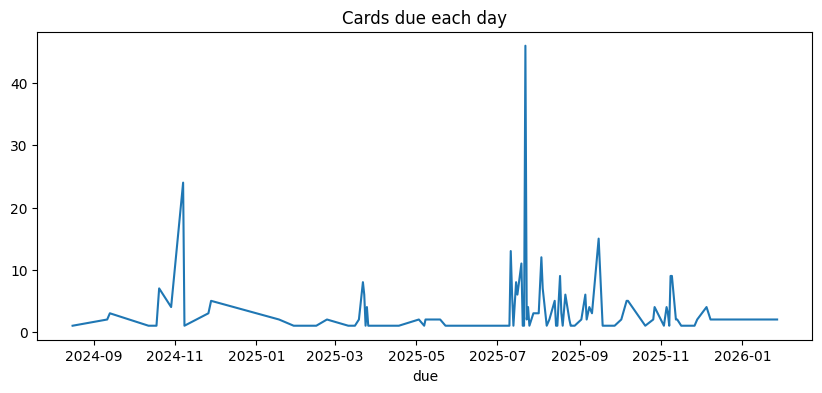

In [ ]:
# Upcoming workload forecast
# for every card, find its *most recent* interval and due-date
latest = (
    reviews.sort_values("when")
    .groupby("card_id")
    .tail(1)[["when", "interval"]]
    .dropna(subset=["interval"])
)
latest["due"] = latest["when"] + pd.to_timedelta(latest.interval, unit="D")
future = latest.groupby(latest["due"].dt.date).size()
future.plot(title="Cards due each day", figsize=(10, 4))

<Axes: title={'center': 'Cumulative cards added'}, xlabel='when'>

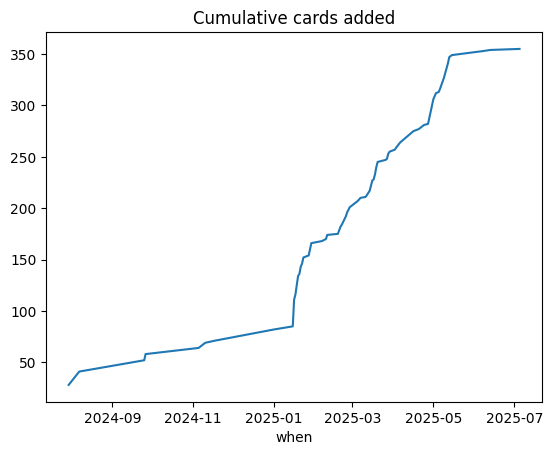

In [14]:
# Deck creation and growth
cards = reviews.sort_values("when").drop_duplicates("card_id", keep="first")
cards.groupby(cards["when"].dt.date).size().cumsum().plot(
    title="Cumulative cards added"
)